In [1]:
import numpy as np 
import pandas as pd
import os, dicom, fnmatch, random, time, cv2

from sklearn import svm
from sklearn.metrics import precision_score, recall_score
from sklearn.cluster import KMeans
from scipy.spatial.distance import cityblock
from scipy.spatial.distance import euclidean
from scipy.stats import entropy 

from sklearn.grid_search import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline

/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
def chisquaredist(array1, array2):
    if len(array1) != len(array2):
        raise ValueError('Input arrays need to be the same size.')
    return sum([ ( (array1[i] - array2[i]) ** 2 ) / (array1[i] + array2[i]) for i in range(len(array1))])

def getFile(directory, ftype):
    matches = []
    for root, dirnames, filenames in os.walk(directory):
        for filename in fnmatch.filter(filenames, '*.'+ftype):
            matches.append(os.path.join(root, filename))
    return matches

def evalClustering(data, min_clust=2, max_clust=31):
    sil_score = []
    for n in range(min_clust, max_clust):
        kmeans = KMeans(n_clusters = n, random_state = 10)
        clt_lab = kmeans.fit_predict(data)
        sil_avg = silhouette_score(data, clt_lab)
        print('for {} clusters, sil score is {}'.format(n, sil_avg))
        sil_score.append(sil_avg)
    
    plt.plot(range(min_clust, max_clust), sil_score)
    plt.title('Average Silhouette Score Scree Plot', fontsize=14)
    ax = plt.axes()
    ax.set_xticks(range(min_clust, max_clust, round((max_clust-min_clust)/10)))
    ax.set_xlabel('Number of clusters (K)')
    ax.set_ylabel('Average Silhouette Score')
    return sil_score

def transformImg(features, centers):
    '''
    * features is a dictionary
    * centers is np array
    '''
    img_hist = {}
    for i in features:
        hist = np.zeros(len(centers))
        feat = features[i]['features']
        for f in feat:
            temp_sim = []
            for center in centers:
                temp_sim.append(euclidean(f, center))
            hist[temp_sim.index(max(temp_sim))] += 1
        img_hist[i] = hist
    return img_hist

def retrieve(train, test, labels):
    '''
    input two histogram represented dataset
    output L1, chi, kL results
    '''
    L1_results = {}
    chi_results = {}
    KL_results = {}
    for i in [1, 0]:
        L1_results[i] = []
        chi_results[i] = []
        KL_results[i] = []
    db_labels = [int(labels[labels.Image == i].Label) for i in train]
    for i in test:
        L1_r = []
        chi_r = []
        KL_r = []
        for j in train:
            query_hist = test[i]
            db_hist = train[j]
            L1_r.append(cityblock(query_hist, db_hist))
            chi_r.append(chisquaredist(query_hist, db_hist))
            KL_r.append(entropy(query_hist, db_hist))
        L1_output = [x for (y, x) in sorted(zip(L1_r, db_labels))]
        chi_output = [x for (y, x) in sorted(zip(chi_r, db_labels))]
        KL_output = [x for (y, x) in sorted(zip([1 if x == float('inf') else x for x in KL_r], db_labels))]
        
        curr_label = int(labels[labels.Image == i].Label)
        L1_results[curr_label].append(L1_output)
        chi_results[curr_label].append(chi_output)
        KL_results[curr_label].append(KL_output)
        
    return L1_results, chi_results, KL_results

def evaluate(d):
    MAP = {}
    MAR = {}
    for i in d:
        MAP[i], MAR[i] = [], []
    for i in d:
        map_temp = []
        mar_temp = []
        for j in d[i]:
            tp, fp, temp_pre, temp_rec = 0, 0, [], []
            for out in j:
                if out == i:
                    tp += 1
                else:
                    fp += 1
                temp_pre.append(tp/(tp+fp))
                temp_rec.append(tp/len(j))
            map_temp.append(mean(temp_pre))
            mar_temp.append(mean(temp_rec))
        MAP[i] = mean(map_temp)
        MAR[i] = mean(mar_temp)
    return MAP, MAR

def displayResults(P, R):
    to_display, p, r = [], [], []
    for (k, v), (k2, v2) in zip(P.items(), R.items()):
        to_display.append([k, v, v2])
        p.append(v)
        r.append(v2)
    to_display.append(['Average', mean(p), mean(r)])
    return pd.DataFrame(to_display, columns=['Type', 'Precision', 'Recall'])

def mean(arr):
    return sum(arr)/len(arr)

In [3]:
labels = pd.read_excel('LIDC_Label.xlsx')
with_nod = labels[labels.Label == 1]
without_nod = labels[labels.Label == 0]

In [4]:
print(with_nod.shape[0])
print(without_nod.shape[0])

883
9469


#### Split [training (70%) and testing (30%)] (90%) and validation (10%)

In [38]:
valid = round(883*0.1)
print(valid)
rest = 883-valid
print(rest)
train = round(rest*0.7)
print(train)
print(rest-train)

88
795
556
239


In [47]:
valid = round(900*0.1)
print(valid)
rest = 900-valid
print(rest)
train = round(rest*0.7)
print(train)
print(rest-train)

90
810
567
243


In [39]:
nod = with_nod.Image.values
no_nod = without_nod.Image.values

In [43]:
nod_train = random.sample(list(nod), 556)
nod_query = random.sample(list(set(nod) - set(nod_train)), 239)
nod_valid = list(set(nod) - set(nod_train) - set(nod_query))

In [46]:
print(len(set(nod_train))+ len(set(nod_query))+ len(set(nod_valid)))

883


### Save params

In [76]:
np.save("var/nod_train.npy", nod_train)
np.save('var/nod_query.npy', nod_query)
np.save('var/nod_valid.npy', nod_valid)

In [48]:
no_nod_subset = []
by_patient = {}
for dcm in no_nod:
    if dcm[20:24] not in by_patient:
        by_patient[dcm[20:24]] = []
        by_patient[dcm[20:24]].append(dcm)
    else:
        by_patient[dcm[20:24]].append(dcm)
for i in by_patient:
    no_nod_subset+= random.sample(by_patient[i], 15)
print(len(no_nod_subset))

900


In [49]:
no_nod_subset[0]

'LIDC-IDRI/LIDC-IDRI-0001/1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288633453246975630178/1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636438705059720603192/000096.dcm'

In [52]:
no_nod_subset_train = random.sample(no_nod_subset, 567)
no_nod_subset_query = random.sample(list(set(no_nod_subset) - set(no_nod_subset_train)), 243)
no_nod_subset_valid = list(set(no_nod_subset) - set(no_nod_subset_query) - set(no_nod_subset_train))

### Save params

In [77]:
np.save('var/no_nod_subset.npy', no_nod_subset)
np.save("var/no_nod_subset_train.npy", no_nod_subset_train)
np.save('var/no_nod_subset_query.npy', no_nod_subset_query)
np.save('var/no_nod_subset_valid.npy', no_nod_subset_valid)

In [55]:
print(len(set(no_nod_subset_train))+len(set(no_nod_subset_query))+len(set(no_nod_subset_valid)))

900


In [56]:
print("Nodule training: {}".format(len(nod_train)))
print("Nodule query: {}".format(len(nod_query)))
print("Nodule validation: {}".format(len(nod_valid)))
print("No nodule training: {}".format(len(no_nod_subset_train)))
print("No nodule query: {}".format(len(no_nod_subset_query)))
print("No nodule validation: {}".format(len(no_nod_subset_valid)))

Nodule training: 556
Nodule query: 239
Nodule validation: 88
No nodule training: 567
No nodule query: 243
No nodule validation: 90


In [57]:
nod_train = [x.replace('.dcm', '.jpg') for x in nod_train]

In [72]:
train = [x.replace('.jpg', '.dcm') for x in nod_train] + no_nod_subset_train
query = nod_query + no_nod_subset_query
valid = nod_valid + no_nod_subset_valid

In [73]:
len(valid)

178

### Save params

In [78]:
np.save('var/train.npy', train)
np.save('var/query.npy', query)
np.save('var/valid.npy', valid)

#### Generate SIFT

##### With nodules

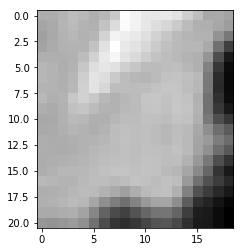

In [59]:
plt.imshow(cv2.cvtColor(cv2.imread(nod_train[0]), cv2.COLOR_BGR2GRAY), cmap='gray')

In [60]:
start = time.time()
SIFT = {}
for nod in nod_train:
    image = cv2.cvtColor(cv2.imread(nod), cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create(nfeatures = 400)
    kp, feat = sift.detectAndCompute(image, None)
    SIFT[nod] = {}
    SIFT[nod]['keypoints'] = kp
    SIFT[nod]['features'] = feat
end = time.time()
print('Time taken: {} seconds'.format(end-start))

Time taken: 0.38730430603027344 seconds


##### Without nodules

In [61]:
start = time.time()
for dcm in no_nod_subset_train:
    dicom_file = dicom.read_file(dcm)
    CT = 255-cv2.convertScaleAbs(dicom_file.pixel_array)
    sift = cv2.xfeatures2d.SIFT_create(nfeatures = 400)
    kp, feat = sift.detectAndCompute(np.uint8(CT), None)
    SIFT[dcm] = {}
    SIFT[dcm]['keypoints'] = kp
    SIFT[dcm]['features'] = feat
end = time.time()
print('Time taken: {} seconds'.format(end-start))

Time taken: 75.89384317398071 seconds


##### Aggregate

In [62]:
SIFT_feat = np.empty((1, 128))
no_SIFT_feat = 0
no_SIFT_slices = []
for i in SIFT:
    try:
        SIFT_feat = np.concatenate([SIFT_feat, SIFT[i]['features']])
    except:
        no_SIFT_slices.append(i)
        no_SIFT_feat+=1
        continue
SIFT_feat = np.delete(SIFT_feat, 0, 0)

In [63]:
print('{} nodules do not have SIFT features.'.format(no_SIFT_feat))

197 nodules do not have SIFT features.


In [64]:
SIFT_feat.shape

(228277, 128)

In [65]:
np.savetxt('to_clust.csv', SIFT_feat, delimiter = ',')

### All training and query images (whole CT scans for those having nodules)

In [66]:
train_images = {}
start = time.time()
for dcm in train:
    dicom_file = dicom.read_file(dcm)
    CT = 255-cv2.convertScaleAbs(dicom_file.pixel_array)
    sift = cv2.xfeatures2d.SIFT_create(nfeatures = 400)
    kp, feat = sift.detectAndCompute(np.uint8(CT), None)
    train_images[dcm] = {}
    train_images[dcm]['keypoints'] = kp
    train_images[dcm]['features'] = feat
end = time.time()
print('Time taken: {} seconds'.format(end-start))

Time taken: 247.00978589057922 seconds


In [67]:
len(train_images.keys())

1123

In [68]:
query_images = {}
start = time.time()
for dcm in query:
    dicom_file = dicom.read_file(dcm)
    CT = 255-cv2.convertScaleAbs(dicom_file.pixel_array)
    sift = cv2.xfeatures2d.SIFT_create(nfeatures = 400)
    kp, feat = sift.detectAndCompute(np.uint8(CT), None)
    query_images[dcm] = {}
    query_images[dcm]['keypoints'] = kp
    query_images[dcm]['features'] = feat
end = time.time()
print('Time taken: {} seconds'.format(end-start))

Time taken: 99.57313203811646 seconds


In [69]:
len(query_images.keys())

482

### Clustering (local)

In [ ]:
# sil_score = evalClustering(SIFT_feat, max_clust=31)

In [ ]:
# kmeans = KMeans(n_clusters=7, random_state=10).fit(SIFT_feat)
# centers = kmeans.cluster_centers_

In [ ]:
# np.bincount(kmeans.labels_)

### Cluster Center From Spark

In [70]:
centers = np.load('var/cluster_centers.npy')

### Transform Images

In [74]:
start = time.time()
database = transformImg(train_images, centers)
end = time.time()
print('Time taken {}'.format(end))

KeyboardInterrupt: 

In [ ]:
len(database.keys())

In [ ]:
queryHist = transformImg(query_images, centers)

In [ ]:
len(queryHist.keys())

In [ ]:
validHist = transformImg(valid)

In [ ]:
labels.head()

In [ ]:
L1_labels, chi_labels, KL_labels = retrieve(database, queryHist, labels)

In [ ]:
L1_labels.keys()

In [ ]:
L1_MAP, L1_MAR = evaluate(L1_labels)
chi_MAP, chi_MAR = evaluate(chi_labels)
KL_MAP, KL_MAR = evaluate(KL_labels)

In [ ]:
displayResults(L1_MAP, L1_MAR)

In [ ]:
displayResults(chi_MAP, chi_MAR)

In [ ]:
displayResults(KL_MAP, KL_MAR)

#### Try SVM

In [ ]:
y = []
for i in database:
    y.append(int(labels[labels.Image == i].Label))

'kernel': ["linear", "poly", "rbf", "sigmoid"]

In [ ]:
for j in ['linear', 'poly', 'rbf', 'sigmoid']:
    print(j)
    clf = svm.SVC(kernel = j)
    clf.fit(np.array(list(database.values())), y)
    pred_label = clf.predict(np.array(list(queryHist.values())))
    true_label = []
    for i in queryHist:
        true_label.append(int(labels[labels.Image == i].Label))
    print(precision_score(true_label, pred_label, average=None))
    print(recall_score(true_label, pred_label, average=None))
    print()
    print(precision_score(true_label, pred_label))
    print(recall_score(true_label, pred_label))
    print()
    print()

In [ ]:
print('a')

In [ ]:
    print(j)
    clf = svm.SVC(kernel = j)
    clf.fit(np.array(list(database.values())), y)
    pred_label = clf.predict(np.array(list(queryHist.values())))
    true_label = []
    for i in queryHist:
        true_label.append(int(labels[labels.Image == i].Label))
    print(precision_score(true_label, pred_label, average=None))
    print(recall_score(true_label, pred_label, average=None))
    print()
    print(precision_score(true_label, pred_label))
    print(recall_score(true_label, pred_label))
    print()
    print()